In [1]:
# # Install some packages
# %pip install rasterio
# %pip install earthpy

In [2]:
# Import packages
import pandas as pd                                                                                 # For loading the data into a DataFrame
import numpy as np                                                                                  # For data manipulation 
import tensorflow as tf                                                                             # For building the model
import rasterio                                                                                     # For reading raster files
import earthpy.plot as ep                                                                           # For plotting the data
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report         # For evaluating the model
from sklearn.utils.class_weight import compute_class_weight                                         # For computing class weights
import matplotlib.pyplot as plt                                                                     # For plotting the data
from matplotlib.colors import from_levels_and_colors                                                # For plotting the data
import os                                                                                           # For setting environment variables

# Suppress TensorFlow INFO and WARNING messages
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.get_logger().setLevel('ERROR')

2024-11-30 08:18:52.001533: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732929532.315183   12910 cuda_dnn.cc:8498] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732929532.429268   12910 cuda_blas.cc:1410] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-30 08:18:53.388965: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# Parameter
ALL_FEATURES = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'EVI', 'NBR', 'NDMI', 'NDWI', 'NDBI', 'NDBaI', 'NDVI', 'elevation']
FEATURES = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'EVI', 'NBR', 'NDMI', 'NDWI', 'NDBI', 'NDBaI', 'NDVI', 'elevation']
# FEATURES = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'EVI', 'NBR', 'NDMI', 'NDWI', 'NDBI', 'NDBaI', 'elevation']
# FEATURES = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'NDVI', 'elevation']
CLASSES = [1, 2, 3, 4, 5, 6, 7, 8, 9]
# CLASSES = [1, 2, 3, 5, 8, 9]
LABEL = ['classvalue']
SPLIT = ['sample']
NUM_CLASSES = len(CLASSES)
NUM_OF_BANDS = len(FEATURES)
PALETTE = ['#F08080', '#D2B48C', '#87CEFA', '#008080', '#90EE90', '#228B22', '#808000', '#006400', '#FF8C00']
# PALETTE = [color for color in PALETTE if PALETTE.index(color) + 1 in CLASSES]
SAMPLE_PATH = 'ndvi_data/Samples_LC_JambiFixedWatersAllFeatures_2023.csv'
IMAGE_PATH = 'ndvi_data/Landsat_Jogja_2023_ALLFEATURES.tif'

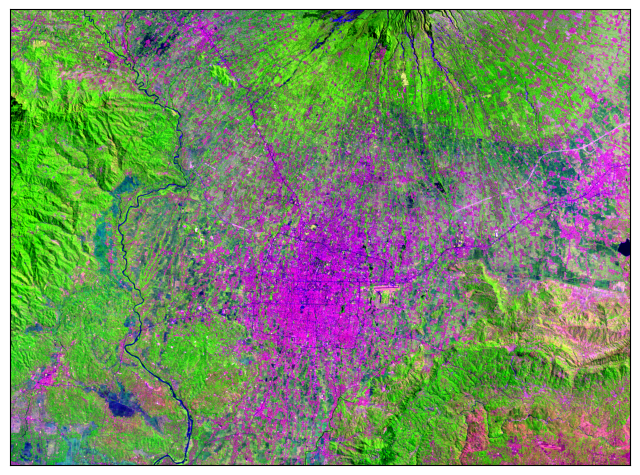

<Axes: >

In [4]:
# Load image
image = rasterio.open(IMAGE_PATH)
bandNum = image.count
height = image.height
width = image.width
crs = image.crs
transform = image.transform
shape = (height, width)

image_vis = []
for x in [6, 5, 4]:
  image_vis.append(image.read(x))
image_vis = np.stack(image_vis)

plot_size = (8, 8)
ep.plot_rgb(
  image_vis,
  figsize=plot_size,
  stretch=True,
)

In [5]:
# Read sample
samples = pd.read_csv(SAMPLE_PATH)
samples = samples.sample(frac = 1) # Shuffle data
samples

,B1,B2,B3,B4,B5,B6,B7,EVI,NBR,NDMI,NDWI,NDBI,NDBaI,NDVI,elevation,classvalue,sample
15871,0.018652,0.024455,0.051240,0.035647,0.332675,0.188713,0.076347,0.544746,0.626683,0.276114,-0.733066,-0.276114,0.423923,0.806433,21,8,train
5429,0.058899,0.078740,0.159562,0.198447,0.130880,0.035854,0.025665,-0.097584,0.672107,0.569928,0.098754,-0.569928,0.165620,-0.205168,7,3,train
17341,0.015352,0.019175,0.048572,0.026710,0.354510,0.165365,0.063752,0.597757,0.695156,0.363828,-0.758995,-0.363828,0.443495,0.859871,20,8,train
15034,0.013785,0.016727,0.056217,0.027232,0.278143,0.132117,0.051845,0.476623,0.685776,0.355933,-0.663731,-0.355933,0.436353,0.821646,8,7,train
15009,0.015682,0.019257,0.056520,0.030120,0.281058,0.133025,0.050965,0.476218,0.693003,0.357495,-0.665144,-0.357495,0.446003,0.806413,7,7,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9784,0.029694,0.032306,0.059408,0.040144,0.403804,0.192081,0.075454,0.648296,0.685122,0.355308,-0.743497,-0.355308,0.435934,0.819151,32,6,train
3275,0.024757,0.032265,0.075660,0.058032,0.279023,0.136518,0.063285,0.398833,0.630245,0.342939,-0.573365,-0.342939,0.366524,0.655650,17,3,train
1040,0.054980,0.066255,0.101428,0.106281,0.287314,0.255400,0.189785,0.316914,0.204420,0.058804,-0.478175,-0.058804,0.147388,0.459946,32,1,test
5192,0.059325,0.076787,0.153512,0.184587,0.122630,0.037710,0.024675,-0.093634,0.664981,0.529625,0.111835,-0.529625,0.208944,-0.201673,7,3,train


In [6]:
# from ydata_profiling import ProfileReport
# ProfileReport(samples[FEATURES], title="Pandas Profiling Report")

In [7]:
# Split into train and test based on column

samples = samples[samples['classvalue'].isin(CLASSES)].reset_index(drop=True)

# Map the class value to integer from 0 to number of classes
label_mapping = {label: idx for idx, label in enumerate(CLASSES)}
samples['classvalue'] = samples['classvalue'].map(label_mapping)

# Split the data into train and test
train = samples[samples['sample'] == 'train']
test = samples[samples['sample'] == 'test']

# Split between features and label
train_features = train[FEATURES]
train_label = train[LABEL]
test_features = test[FEATURES]
test_label = test[LABEL]

# Function to reshape array input
def reshape_input(array):
    return np.expand_dims(array, axis=-1)

# Convert samples dataframe (pandas) to numpy array
train_input = reshape_input(train_features.to_numpy())
test_input = reshape_input(test_features.to_numpy())

# Also make label data to categorical
train_output = tf.keras.utils.to_categorical(train_label.to_numpy(), num_classes=NUM_CLASSES)
test_output = tf.keras.utils.to_categorical(test_label.to_numpy(), num_classes=NUM_CLASSES)

# Show the data shape
print(f'Train features: {train_input.shape}\nTest features: {test_input.shape}\nTrain label: {train_output.shape}\nTest label: {test_output.shape}')

Train features: (17316, 15, 1)
Test features: (3681, 15, 1)
Train label: (17316, 9)
Test label: (3681, 9)


In [8]:
filtered_train = train[FEATURES + LABEL]
Label0 = filtered_train[filtered_train['classvalue'] == 0]
Label1 = filtered_train[filtered_train['classvalue'] == 1]
Label2 = filtered_train[filtered_train['classvalue'] == 2]
Label3 = filtered_train[filtered_train['classvalue'] == 3]
Label4 = filtered_train[filtered_train['classvalue'] == 4]
Label5 = filtered_train[filtered_train['classvalue'] == 5]
Label6 = filtered_train[filtered_train['classvalue'] == 6]
Label7 = filtered_train[filtered_train['classvalue'] == 7]
Label8 = filtered_train[filtered_train['classvalue'] == 8]

print("Label 0", Label0["classvalue"].count())
print("Label 1", Label1["classvalue"].count())
print("Label 2", Label2["classvalue"].count())
print("Label 3", Label3["classvalue"].count())
print("Label 4", Label4["classvalue"].count())
print("Label 5", Label5["classvalue"].count())
print("Label 6", Label6["classvalue"].count())
print("Label 7", Label7["classvalue"].count())
print("Label 8", Label8["classvalue"].count())

Label 0 853
Label 1 1171
Label 2 2930
Label 3 1577
Label 4 664
Label 5 3027
Label 6 2115
Label 7 2820
Label 8 2159


In [9]:
# Make model for our data
# Input shape
train_shape = train_input.shape
input_shape = (None, 1)

# Model parameter
neuron = 64
drop = 0.4
kernel = 2
pool = 2

# Make sequential model
model = tf.keras.Sequential([
  tf.keras.Input(input_shape),
  tf.keras.layers.Conv1D(neuron * 2, kernel, activation='relu'),
  tf.keras.layers.Conv1D(neuron * 2, kernel, activation='relu'),
  tf.keras.layers.AveragePooling1D(pool),
  tf.keras.layers.Dropout(drop),
  tf.keras.layers.Conv1D(neuron * 1, kernel, activation='relu'),
  tf.keras.layers.Conv1D(neuron * 1, kernel, activation='relu'),
  tf.keras.layers.AveragePooling1D(pool),
  tf.keras.layers.Dropout(drop),
  tf.keras.layers.GlobalAveragePooling1D(),
  
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dense(neuron * 2, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.05)),
  tf.keras.layers.Dropout(drop),
  tf.keras.layers.Dense(neuron * 1, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.05)),
  tf.keras.layers.Dropout(drop),
  tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

init_model_weights = model.get_weights()

model.summary()

I0000 00:00:1732929553.229770   12910 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1939 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050, pci bus id: 0000:10:00.0                                                   , compute capability: 8.6


AttributeError: module 'ml_dtypes' has no attribute 'float8_e3m4'


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, None, 128)      │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, None, 128)      │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling1d               │ (None, None, 128)      │             0 │
│ (AveragePooling1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, None, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, None, 64)       │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, None, 64)       │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling1d_1             │ (None, None, 64)       │             0 │
│ (AveragePooling1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, None, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 9)              │           585 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 75,401 (294.54 KB)

 Trainable params: 75,273 (294.04 KB)

 Non-trainable params: 128 (512.00 B)

In [10]:
# Train the model
# Reset states generated by Keras
tf.keras.backend.clear_session()

# Reset the weights
model.set_weights(init_model_weights)

train_output_flat = np.argmax(train_output, axis=1)

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(train_output_flat), y=train_output_flat)
class_weights = dict(enumerate(class_weights))

print(class_weights)

# Compline the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='CategoricalCrossentropy',
    metrics=['accuracy']
)

# Create callback to stop training if loss not decreasing
stop = tf.keras.callbacks.EarlyStopping(
    monitor='loss',
    patience=10,
    restore_best_weights=True
)

lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    patience=5,
    factor=0.5,
    min_lr=1e-6
)

# Fit the model
result = model.fit(
    x=train_input, y=train_output,
    validation_data=(test_input, test_output),
    batch_size=1024,
    callbacks=[stop, lr_callback],  
    epochs=500,
    class_weight=class_weights
)

{0: np.float64(2.2555685814771396), 1: np.float64(1.6430401366353544), 2: np.float64(0.6566552901023891), 3: np.float64(1.2200380469245402), 4: np.float64(2.897590361445783), 5: np.float64(0.6356128179715891), 6: np.float64(0.909692671394799), 7: np.float64(0.6822695035460993), 8: np.float64(0.8911533117183882)}
Epoch 1/500


I0000 00:00:1732929560.172406   13093 service.cc:152] XLA service 0x7fa2a4014720 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732929560.172441   13093 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3050, Compute Capability 8.6
2024-11-30 08:19:20.400709: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1732929560.840016   13093 cuda_dnn.cc:529] Loaded cuDNN version 90300
2024-11-30 08:19:27.404462: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'input_reduce_transpose_fusion', 84 bytes spill stores, 76 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_transpose_fusion_1', 276 bytes spill stores, 264 bytes spill loads

I0000 00:00:1732929567.424485   130

17/17 ━━━━━━━━━━━━━━━━━━━━ 21s 712ms/step - accuracy: 0.1111 - loss: 10.7134 - val_accuracy: 0.0916 - val_loss: 10.5118 - learning_rate: 1.0000e-04
Epoch 2/500
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.1300 - loss: 10.4441 - val_accuracy: 0.0916 - val_loss: 10.2742 - learning_rate: 1.0000e-04
Epoch 3/500
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.1468 - loss: 10.2162 - val_accuracy: 0.1385 - val_loss: 10.0432 - learning_rate: 1.0000e-04
Epoch 4/500
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.1557 - loss: 9.9437 - val_accuracy: 0.1516 - val_loss: 9.8178 - learning_rate: 1.0000e-04
Epoch 5/500
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.1566 - loss: 9.7267 - val_accuracy: 0.1546 - val_loss: 9.5984 - learning_rate: 1.0000e-04
Epoch 6/500
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.1763 - loss: 9.4762 - val_accuracy: 0.1548 - val_loss: 9.3847 - learning_rate: 1.0000e-04
Epoch 7/500
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.1784 - 

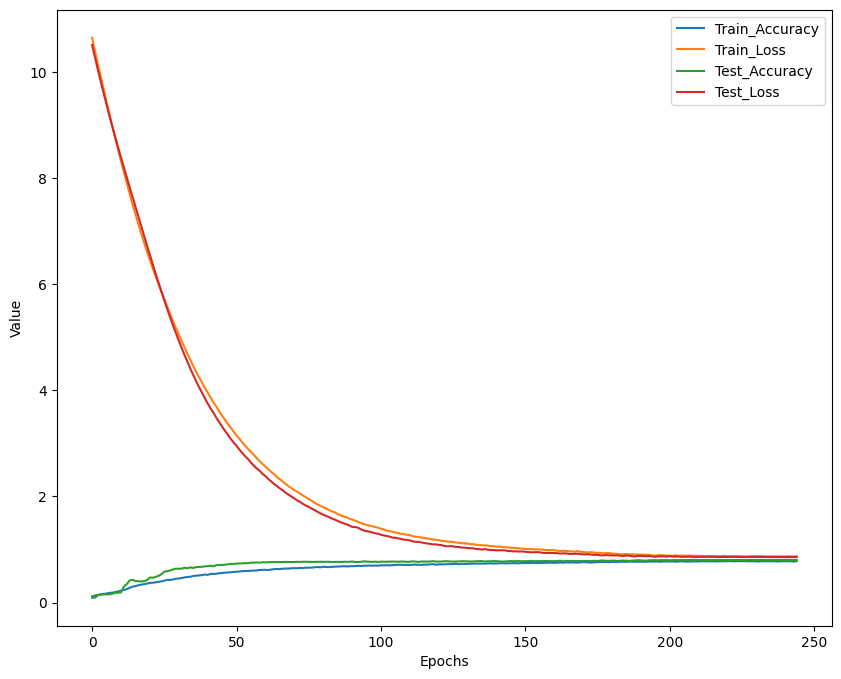

In [11]:
# Show history
history = pd.DataFrame(result.history)

plt.figure(figsize = (10, 8))
plt.plot(range(len(history['accuracy'].values.tolist())), history['accuracy'].values.tolist(), label = 'Train_Accuracy')
plt.plot(range(len(history['loss'].values.tolist())), history['loss'].values.tolist(), label = 'Train_Loss')
plt.plot(range(len(history['val_accuracy'].values.tolist())), history['val_accuracy'].values.tolist(), label = 'Test_Accuracy')
plt.plot(range(len(history['val_loss'].values.tolist())), history['val_loss'].values.tolist(), label = 'Test_Loss')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()
plt.show()

116/116 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
              precision    recall  f1-score   support

           0       1.00      0.94      0.97       242
           1       0.74      0.95      0.83       273
           2       0.94      0.96      0.95       626
           3       0.93      0.68      0.79       676
           4       0.66      0.87      0.75       337
           5       0.82      0.70      0.76       632
           6       0.60      0.75      0.67       361
           7       0.71      0.67      0.69       383
           8       0.86      0.95      0.91       151

    accuracy                           0.80      3681
   macro avg       0.81      0.83      0.81      3681
weighted avg       0.82      0.80      0.80      3681



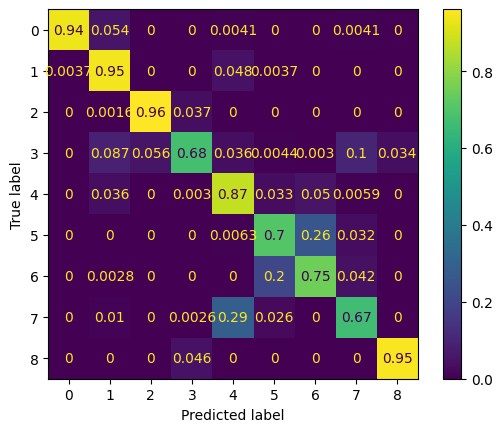

In [12]:
# Predict test data
prediction = np.argmax(model.predict(test_input), 1).flatten()
label = np.argmax(test_output, 1).flatten()

# Confusion matrix
cm = confusion_matrix(label, prediction, normalize='true')
cm = ConfusionMatrixDisplay(cm)
cm.plot()

# Classification report
print(classification_report(label, prediction))

2024-11-30 08:20:31.243814: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 151895040 exceeds 10% of free system memory.
2024-11-30 08:20:31.404931: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 151895040 exceeds 10% of free system memory.
2024-11-30 08:20:33.357125: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_bfc) ran out of memory trying to allocate 580.69MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-11-30 08:20:33.357211: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_bfc) ran out of memory trying to allocate 580.69MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-11-30 08:20:33.406717: W external/local_xla/xla/tsl/frame

29/31 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step

2024-11-30 08:20:37.387601: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_bfc) ran out of memory trying to allocate 991.50MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 125ms/step


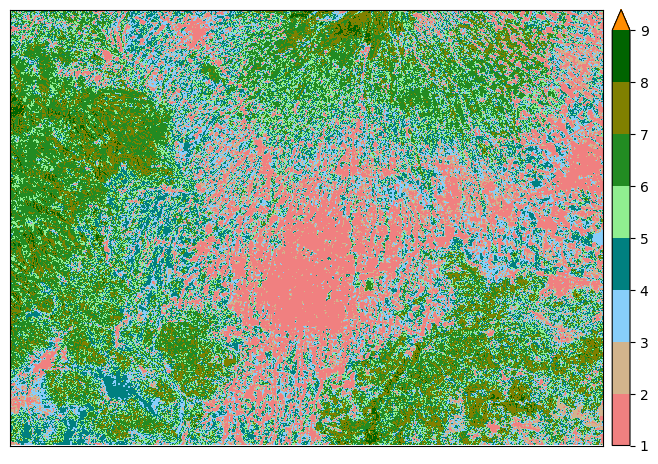

Nilai nodata: None


In [13]:
# Predict image using the model
from scipy.ndimage import gaussian_filter
BLUR = 0

image_input = []
used_image_feature = [i + 1 for i in range(0, len(ALL_FEATURES)) if image.descriptions[i] in FEATURES]
for i in used_image_feature:
  image_input.append(gaussian_filter(image.read(i), sigma=BLUR))
image_input = reshape_input(np.stack(image_input).reshape(NUM_OF_BANDS, -1).T)

# Predict
prediction = model.predict(image_input, batch_size=4096*20)
prediction = np.argmax(prediction, 1)
prediction = prediction.reshape(shape[0], shape[1])

# Visualize
cmap, norm = from_levels_and_colors(CLASSES, PALETTE, extend='max')
ep.plot_bands(prediction + 1, cmap=cmap, norm=norm, figsize=plot_size)

nodata_value = image.nodata
print("Nilai nodata:", nodata_value)

In [14]:
# Saving the Model

MODEL_SAVED_PATH = 'saved_data/'
MODEL_NAME = 'NDVI_CNN_V1.keras'

model.save(MODEL_SAVED_PATH + MODEL_NAME)